# Discretization of the MIT dataset house 1

In [1]:
%matplotlib inline

# Hacky solution to set the working path to the parent folder (upis)
# It is supposed to execute only once
import os, sys
if os.getcwd().find('notebooks') >= 0:
    os.chdir(os.getcwd() + '/..')
    sys.path.append(os.getcwd() + '/sourcecode')

import matplotlib.pyplot as plt

from DataProcessor import DataProcessor
from Parser import DatasetPath
from Headers import SensorProcessedDataHeaders

The dataset comes as the input of 3 separated files, but there is already implemented a script to process them and keep only the most important information for the learning algorithms. Let's start by first reading the dataset and process it to a structure with the sensor id, the activity label and two timestamps indicating the start and end.

In [2]:
path = DatasetPath.MIT1

dp = DataProcessor(path=path)
data = dp.process_sensors()

data.head()

,SENSOR_ID,ACTIVITY,START,END
0,100,Bathing,2003-04-01 20:51:52,2003-04-01 21:05:20
1,68,Bathing,2003-04-01 20:51:58,2003-04-01 20:52:05
2,81,Bathing,2003-04-01 20:53:36,2003-04-01 20:53:43
3,101,Bathing,2003-04-01 20:53:49,2003-04-01 21:21:43
4,93,Bathing,2003-04-01 20:53:52,2003-04-01 20:58:42


As we can see, it is difficult to indicate how long the sensor has been active only from the two timestamps. Let's create a new column which indicates this.

Why do we do this?

Because classification algorithms do not handle well timestamps. They do not have the capability to deduce that the day repeats every 24h. We could build a custom algorithm, or we can process the data to discretise the timestamps by the period they start and how long did they last.

In [3]:
data['duration'] = data[SensorProcessedDataHeaders.END] - data[SensorProcessedDataHeaders.START]

data.head()

,SENSOR_ID,ACTIVITY,START,END,duration
0,100,Bathing,2003-04-01 20:51:52,2003-04-01 21:05:20,00:13:28
1,68,Bathing,2003-04-01 20:51:58,2003-04-01 20:52:05,00:00:07
2,81,Bathing,2003-04-01 20:53:36,2003-04-01 20:53:43,00:00:07
3,101,Bathing,2003-04-01 20:53:49,2003-04-01 21:21:43,00:27:54
4,93,Bathing,2003-04-01 20:53:52,2003-04-01 20:58:42,00:04:50


Now that we have the duration, let's sort them, because we want to see what is their distribution and sorting them helps making better decisions.

In [4]:
duration = data['duration'].copy()

duration.sort_values(inplace=True)

duration.head()

1227   00:00:01
1738   00:00:01
2523   00:00:01
1748   00:00:01
2521   00:00:01
Name: duration, dtype: timedelta64[ns]

As we can see, we have repeated values. Let's convert them into seconds and count the frequency of each unique value.

In [5]:
duration_seconds = duration.apply(lambda x: x.total_seconds())

print('These are the 10 most frequent durations')
print(duration_seconds.value_counts().head(10))

print('\nThese are the 10 least frequent durations')
print(duration_seconds.value_counts().tail(10))

print('\nAnd in total we have', duration_seconds.value_counts().shape[0], 'different values')

These are the 10 most frequent durations
3.0     291
2.0     289
1.0     229
4.0     167
5.0     127
7.0     110
6.0      98
8.0      74
12.0     63
10.0     58
Name: duration, dtype: int64

These are the 10 least frequent durations
550.0      1
2190.0     1
247.0      1
9291.0     1
242.0      1
3833.0     1
118.0      1
10152.0    1
4466.0     1
30768.0    1
Name: duration, dtype: int64

And in total we have 545 different values


In [6]:
def frequency_bigger_than(count):
    return duration_seconds.value_counts()[duration_seconds.value_counts() > count]

print('Also, there are', frequency_bigger_than(0).shape[0] - frequency_bigger_than(1).shape[0], 'which only occur one time')

Also, there are 401 which only occur one time


As we can see we have 401 sensor activities that occur only one time. Can we discard them? Well, no. Given that the precision is to the second the same activity may not last always the same. So, let's cluster them to allow better decisions (we do this because we have too many single values which would deteriorate the perform of a Randon Forest).

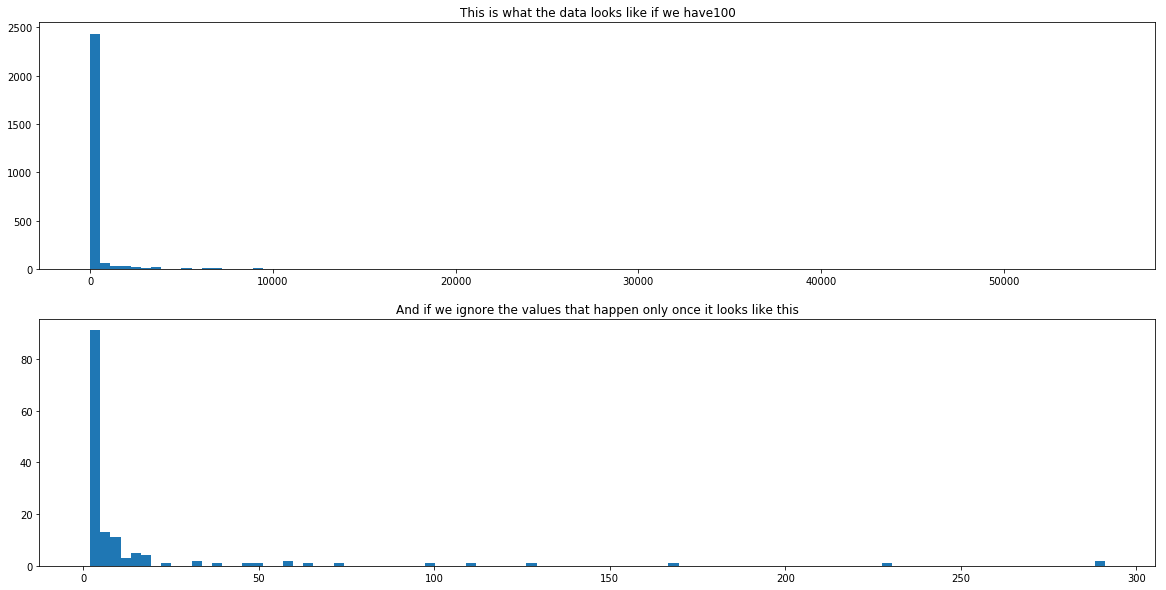

In [7]:
n_bins = 100

plt.figure(figsize=(20,10))

plt.subplot(2,1,1)
plt.title('This is what the data looks like if we have' + str(n_bins))
plt.hist(duration_seconds, bins=n_bins)

plt.subplot(2,1,2)
plt.title('And if we ignore the values that happen only once it looks like this')
plt.hist(frequency_bigger_than(1), bins=n_bins)
plt.ioff()

In [8]:
percentile = 0.75

print(percentile, 'of the total values last, at most,', duration_seconds.quantile(percentile), 'seconds')

0.75 of the total values last, at most, 43.0 seconds


So, 25% of the values last more than 43 seconds. From now on, let's not consider more these values for a while and let's focus on the other 75%.

In [9]:
long_duration = duration_seconds[duration_seconds >= 43]

Now that we stored on another variable all the durations longer or equal to 43 seconds, let's remove them from the variable we are analysing.

In [10]:
duration_seconds = duration_seconds[duration_seconds < 43]

print('Total of', duration_seconds.shape[0], 'rows')

Total of 2074 rows


Let's plot it again

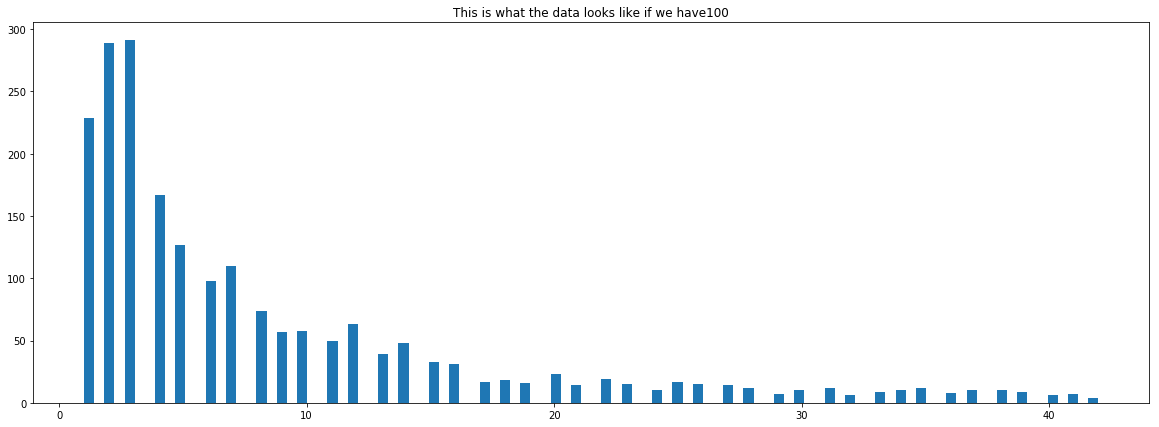

In [11]:
plt.figure(figsize=(20,7))

plt.title('This is what the data looks like if we have' + str(n_bins))
plt.hist(duration_seconds, bins=n_bins)

plt.ioff()

In [12]:
percentile = 0.75

print(percentile, 'of the total values last, at most,', duration_seconds.quantile(percentile), 'seconds')

0.75 of the total values last, at most, 12.0 seconds


Now, 25% of the values last longer than 12 seconds. Let's also separate these.

In [13]:
medium_duration = duration_seconds[duration_seconds >= 12]

duration_seconds = duration_seconds[duration_seconds < 12]

print('Total of', duration_seconds.shape[0], 'rows')

Total of 1550 rows


And again we plot

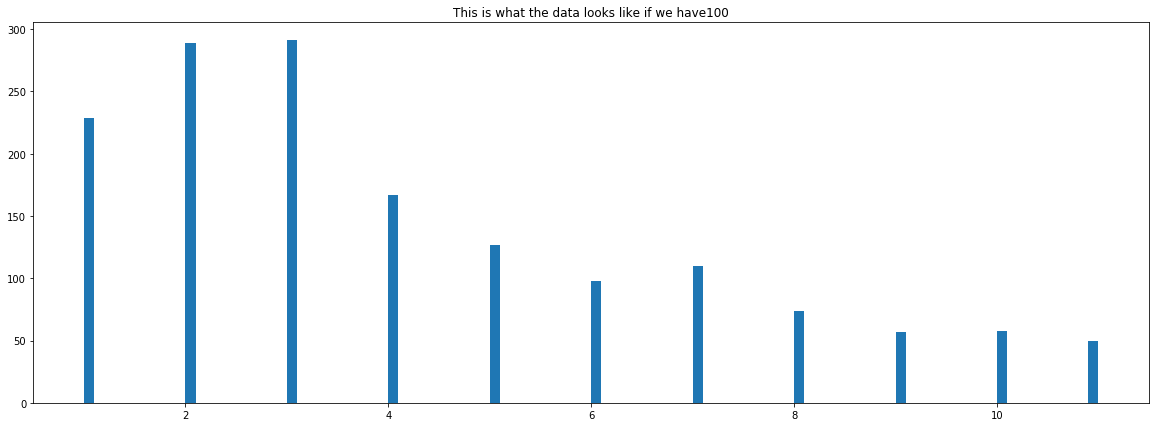

In [14]:
plt.figure(figsize=(20,7))

plt.title('This is what the data looks like if we have' + str(n_bins))
plt.hist(duration_seconds, bins=n_bins)

plt.ioff()

In a more numerical perspective:

In [15]:
duration_seconds.value_counts()

3.0     291
2.0     289
1.0     229
4.0     167
5.0     127
7.0     110
6.0      98
8.0      74
10.0     58
9.0      57
11.0     50
Name: duration, dtype: int64

In [16]:
percentile = 0.5

print(percentile, 'of the total values last, at most,', duration_seconds.quantile(percentile), 'seconds')

0.5 of the total values last, at most, 3.0 seconds


What can we deduce? Fast activities are very common. 50% of them last 3 seconds. Due to the small range of values (1 to 11 seconds), let's separate these into two groups of equal size.

In [17]:
short_duration = duration_seconds[duration_seconds > 3]

ultra_short_duration = duration_seconds[duration_seconds <= 3]

So, now we divided into 4 clusters: ultra short, short, medium and long. However, this split is not statistically significant without analyse the variables with more detail and look better on the context. Anyway, the process chosen for now is trial and error, and this analysis should be enough.

In [18]:
print('There are', ultra_short_duration.shape[0], 'ultra short values (vales <= 3 seconds)')
print('There are', short_duration.shape[0], 'short values (3 < values < 12)')
print('There are', medium_duration.shape[0], 'medium values (12 <= values < 43)')
print('There are', long_duration.shape[0], 'long values (>= 43 seconds)')

total_values = ultra_short_duration.shape[0] + short_duration.shape[0] + medium_duration.shape[0] + long_duration.shape[0]

print('\nIn total there are', total_values, 'values which is the same number as the ' +
      'number of rows of the original processed data (', duration.shape[0], ')')

There are 809 ultra short values (vales <= 3 seconds)
There are 741 short values (3 < values < 12)
There are 524 medium values (12 <= values < 43)
There are 698 long values (>= 43 seconds)

In total there are 2772 values which is the same number as the number of rows of the original processed data ( 2772 )


### Let's close this chapter where we analyse the duration of the events, and now focus on the starting period.

Let's start to see when the dataset start and when does it end.

In [19]:
data[SensorProcessedDataHeaders.START].min()

Timestamp('2003-03-27 06:43:40')

In [20]:
data[SensorProcessedDataHeaders.END].max()

Timestamp('2003-04-11 22:24:17')

In [21]:
time_delta = data[SensorProcessedDataHeaders.END].max() - data[SensorProcessedDataHeaders.START].min()
time_delta

Timedelta('15 days 15:40:37')

We now know that the dataset was collected in 2003 during March and April and it lasted 2 weeks (15 days). But what about their occurrence during the day? Let's just keep the hour

In [22]:
hours = data[SensorProcessedDataHeaders.START].apply(lambda x: x.hour)

hours.value_counts()

15    313
13    285
11    274
7     189
9     177
12    176
16    171
14    166
19    145
20    139
18    138
17    113
8     110
6      93
10     78
21     77
22     76
0      27
23     17
4       6
1       2
Name: START, dtype: int64

# TODO

 - Convert hours to periods of the day (e.g., morning, afternoon, evening, night)
 - Convert to days of the week (weekdays and weekends or more granular and identify each day)